In [2]:
import numpy as np
from scipy.stats import pearsonr
import sys
sys.path.append('/home/sedroc/Bachelor/FEPCEU')

from data.data_retriever import Dataretreiver

In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
data = Dataretreiver(reduce='pca_pure', debug=True)


/home/sedroc/Bachelor/FEPCEU/data/data_retriever.py:155: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').ffill()
/home/sedroc/Bachelor/FEPCEU/data/data_retriever.py:156: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/sedroc/Bachelor/FEPCEU/data/data_retriever.py:165: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  complete_date_range = pd.date_range(start=start_date, end=end_date, freq='H')
/home/sedroc/Bachelor/FEPCEU/data/data_retriever.py:198: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').ffill()
/home/sedroc/Bachelor/FEPCEU/data/data_retriever.py:198: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
 

Filling missing values
Start date: 2024-01-01 00:00:00
End date: 2024-12-31 23:00:00
Total expected hours: 8784
Hours in original data: 8783
Missing hours filled: 1
Hours in complete data: 8784
Expected hours for the year: 8784
Top columns selected: ['sun_area_36', 'sun_area_21', 'sun_area_31', 'sun_area_6', 'sun_area_5', 'sun_area_1', 'sun_area_16', 'sun_area_11', 'sun_area_4', 'sun_area_22']
Total variance explained with the 10 columns: 98.06%
Top columns selected: ['wind_area_5', 'wind_area_36', 'wind_area_31', 'wind_area_15', 'wind_area_29', 'wind_area_40', 'wind_area_1', 'wind_area_20', 'wind_area_2', 'wind_area_25']
Total variance explained with the 10 columns: 96.63%
Top columns selected: ['temp_area_25', 'temp_area_15', 'temp_area_36', 'temp_area_40', 'temp_area_14', 'temp_area_11', 'temp_area_39', 'temp_area_20', 'temp_area_19', 'temp_area_37']
Total variance explained with the 10 columns: 98.95%


In [24]:
last_date = wind_df.index[-1]
elec_df = elec_df[:last_date]
wind_df.tail(), elec_df.tail()

(                     wind_area_1  wind_area_10  wind_area_11  wind_area_12  \
 time                                                                         
 2024-12-27 11:00:00         4.41          7.86          3.73          5.38   
 2024-12-27 12:00:00         4.63          8.11          3.84          5.33   
 2024-12-27 13:00:00         4.82          7.99          3.66          5.34   
 2024-12-27 14:00:00         5.00          7.88          3.49          5.36   
 2024-12-27 15:00:00         5.19          7.76          3.31          5.37   
 
                      wind_area_13  wind_area_14  wind_area_15  wind_area_16  \
 time                                                                          
 2024-12-27 11:00:00          5.97          7.17          8.15          3.14   
 2024-12-27 12:00:00          6.08          7.24          8.39          3.18   
 2024-12-27 13:00:00          5.89          7.22          8.26          3.18   
 2024-12-27 14:00:00          5.70          7

In [23]:
# Step 1: Compute correlation between each wind speed column and the target price
correlations = {}
for col in wind_df.columns:
    corr, _ = pearsonr(wind_df[col], elec_df['price'])
    correlations[col] = corr

# Step 2: Sort by absolute correlation strength
sorted_cols = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

# Step 3: Select top N wind points
n_points = 10  # you can adjust this
top_columns = [col for col, corr in sorted_cols[:n_points]]
print(sorted_cols)
print(f"Top {n_points} wind points most correlated with price:")
for col in top_columns:
    print(f"{col}: correlation = {correlations[col]:.4f}")

# Step 4: Create a reduced feature DataFrame
reduced_data = wind_df[top_columns]

# Now 'reduced_data' is ready to be used in your ML model (aligned with 'target')

# Optional: you can join target if you want a complete training DataFrame
full_training_data = reduced_data.join(elec_df)

print("\nReduced feature set (head):")
print(full_training_data.head())


[('wind_area_12', -0.40162747811411526), ('wind_area_13', -0.39809657403550075), ('wind_area_17', -0.3916347747278248), ('wind_area_16', -0.390730957731928), ('wind_area_18', -0.3902319146645092), ('wind_area_27', -0.3849003403791002), ('wind_area_7', -0.3842940603342456), ('wind_area_11', -0.3811815131552826), ('wind_area_6', -0.3740408545091373), ('wind_area_22', -0.3727621975726626), ('wind_area_2', -0.37176685901209594), ('wind_area_8', -0.36851617943195325), ('wind_area_21', -0.363574350306325), ('wind_area_37', -0.36212251803868306), ('wind_area_33', -0.3614434783935596), ('wind_area_32', -0.36011474983047803), ('wind_area_3', -0.36009715491505934), ('wind_area_38', -0.3596593851014564), ('wind_area_23', -0.3580389529881326), ('wind_area_1', -0.3519584450561188), ('wind_area_31', -0.35124762922946146), ('wind_area_26', -0.3497958021170542), ('wind_area_28', -0.34897522063884356), ('wind_area_36', -0.34299747215978527), ('wind_area_19', -0.34130173186580287), ('wind_area_14', -0.3

PCA explained variance ratio: 88.35% total variance retained

Selected representative wind points:
['wind_area_22', 'wind_area_34', 'wind_area_7', 'wind_area_10', 'wind_area_16', 'wind_area_32', 'wind_area_24', 'wind_area_31', 'wind_area_6', 'wind_area_4']

Reduced feature set (head):
                     wind_area_22  wind_area_34  wind_area_7  wind_area_10  \
time                                                                         
2024-01-01 00:00:00          0.97         11.98         4.73          7.12   
2024-01-01 01:00:00          0.66         11.15         4.02          6.46   
2024-01-01 02:00:00          0.34         10.33         3.31          5.79   
2024-01-01 03:00:00          0.03          9.50         2.60          5.13   
2024-01-01 04:00:00          0.17          8.72         2.04          7.00   

                     wind_area_16  wind_area_32  wind_area_24  wind_area_31  \
time                                                                          
2024-01-0

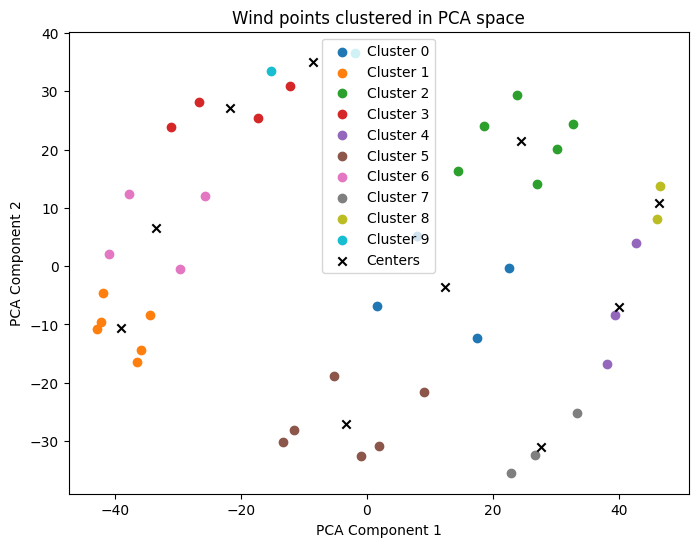

In [26]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Standardize the features across time (important before PCA!)
scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(wind_df),
    index=wind_df.index,
    columns=wind_df.columns
)

# Step 2: Apply PCA
n_pca_components = 10  # how many principal components to keep
pca = PCA(n_components=n_pca_components)
pca_features = pca.fit_transform(data_scaled.T)  # Notice transpose: (100 points, 500 times) --> (100, 10)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_.sum():.2%} total variance retained")

# Step 3: Cluster the PCA-transformed points
n_clusters = 10  # how many spatial points to select
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(pca_features)

# Step 4: For each cluster, select representative point (closest to cluster center)
representatives = []
for cluster_id in range(n_clusters):
    cluster_indices = np.where(labels == cluster_id)[0]
    cluster_points = pca_features[cluster_indices]
    center = kmeans.cluster_centers_[cluster_id]
    closest_idx = cluster_indices[np.argmin(np.linalg.norm(cluster_points - center, axis=1))]
    representatives.append(wind_df.columns[closest_idx])

print("\nSelected representative wind points:")
print(representatives)

# Step 5: Create reduced dataset with selected points
reduced_data = wind_df[representatives]

# Optionally join with target for modeling
full_training_data = reduced_data.join(elec_df)

print("\nReduced feature set (head):")
print(full_training_data.head())

# Optional: Plot clustering if you want to visualize
plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(pca_features[idx, 0], pca_features[idx, 1], label=f'Cluster {label}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black', marker='x', label='Centers')
plt.title('Wind points clustered in PCA space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()
